# Performance Predictor (PP) test calibrators

Test calibrators:

- The fact that the average prediction (PP accuracy in your tables) is so far off the target (the SVC accuracy), means that the calibration is off. Even if the performance predictor didn't learn anything at all, if it was well-calibrated it would just output the test set accuracy as its guess, and so at least on the test set it should get the right score. But there are lots of ways to calibrate, and sometimes some work better than others. The default is 'shift', but the other possibilities are: 'confidence_bins', 'linear_extrapolation', and 'isotonic_regression'

In this notebook, we will do the following
  - Start with the Clinc 150 dataset
    - Use the 90 classes with the lowest class accuracy size
      - 90 classes deteremined in notebook: 
        - 'clinc 150 - filter accuracy ordered classes to 0.80 acc and 90 classes.ipynb'
    - Randomize the dataset.
      - Train set is first 4,500 examples in randomized dataset. 
        - Mimics the size of the representative workspace
      - Remaining 9000 can be used to fit PP.
    - Create base SVC model with the train set.
  - Run the basic PP ShortTextClassificationWrapper varying the PP calibration.
    - calibrations = ['shift', 'confidence_bins', 'linear_extrapolation',  'isotonic_regression']
  - Results
    - Gather the y_pred and y_score
    - Display the SVC and PP accuracies as well as TH/TL/FH/FL for each run

In [1]:
import gzip
from IPython.display import display, HTML
import io
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.utils import shuffle
import tensorflow as tf
import time
from typing import List

from uq360.algorithms.blackbox_metamodel.short_text_classification import ShortTextClassificationWrapper

os.environ["PYTHONWARNINGS"] = 'ignore'

tf.get_logger().setLevel(logging.ERROR)

pd.options.display.max_colwidth = 100

%load_ext autoreload
%autoreload 2

# Increase the width of the notebook so that it is the width of the browser 
# which allows larger size for the dashboard
display(HTML('<style>.container { width:100% !important; }</style>'))

2022-08-10 21:01:52.986012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-10 21:01:52.986043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Load workspace dataset

In [2]:
json_gzip_file = '../../../data/clinc150/data_full.json.gzip'
with gzip.open(json_gzip_file, 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))
datasets = {}
for k,v in data.items():
    datasets[k] = []
    for i in v:
        datasets[k].append({'intent': i[1], 'example':i[0]})
dfs = {}
for k,v in datasets.items():
    dfs[k] = pd.DataFrame(v)
#     print(f'{k} n_xmp {len(dfs[k])}')
#     print(f'{k} n_int {len(np.unique(dfs[k]["intent"].to_numpy()))}')
#     display(HTML(dfs[k].head(1).to_html()))

#### Extract the X and Y values for each of the datasets

In [3]:
x_tr = dfs['train']['example'].to_numpy()
x_te = dfs['test']['example'].to_numpy()
x_va = dfs['val']['example'].to_numpy()
y_tr = dfs['train']['intent'].to_numpy().ravel()
y_te = dfs['test']['intent'].to_numpy().ravel()
y_va = dfs['val']['intent'].to_numpy().ravel()
x_co = np.concatenate((x_tr, x_te, x_va))
y_co = np.concatenate((y_tr, y_te, y_va))

print(f'x_tr.shape  = {x_tr.shape}')
print(f'y_tr.shape  = {y_tr.shape}')
print(f'x_te.shape  = {x_te.shape}')
print(f'y_te.shape  = {y_te.shape}')
print(f'x_va.shape  = {x_va.shape}')
print(f'y_va.shape  = {y_va.shape}')
print(f'x_co.shape  = {x_co.shape}')
print(f'y_co.shape  = {y_co.shape}')

x_tr.shape  = (15000,)
y_tr.shape  = (15000,)
x_te.shape  = (4500,)
y_te.shape  = (4500,)
x_va.shape  = (3000,)
y_va.shape  = (3000,)
x_co.shape  = (22500,)
y_co.shape  = (22500,)


#### Encode with USE encoder

In [4]:
%%time
class MiniLMEmbedding:
    def __init__(self):
        self.transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    def encode(self, input_sentences: List[str]) -> np.array:
        sentences = [sentence.lower() for sentence in input_sentences]
        embedded_sentences = [self.embed_sentence(s) for s in sentences]
        return np.array(embedded_sentences)
    def embed_sentence(self, sentence: str) -> np.array:
        embedding = self.transformer.encode(sentence, show_progress_bar=False, convert_to_numpy=True)
        return embedding

encoded_file = '../../../data/clinc150/x_co_encoded.csv'
if os.path.exists(encoded_file):
    df = pd.read_csv(encoded_file, header=None)
    x_co_encoded = df.to_numpy()
else:
    encoder = MiniLMEmbedding()

    start = time.time()
    x_tr_encoded = encoder.encode(x_tr)
    print(f'done tr dur={time.time() - start}')

    start = time.time()
    x_te_encoded = encoder.encode(x_te)
    print(f'done te dur={time.time() - start}')

    start = time.time()
    x_va_encoded = encoder.encode(x_va)
    print(f'done va dur={time.time() - start}')

    start = time.time()
    x_co_encoded = np.concatenate((x_tr_encoded, x_te_encoded, x_va_encoded))
    print(f'done co dur={time.time() - start}')
    start = time.time()

    print(f'x_tr_encoded.shape = {x_tr_encoded.shape}')
    print(f'x_te_encoded.shape = {x_te_encoded.shape}')
    print(f'x_va_encoded.shape = {x_va_encoded.shape}')

    # Save to file
    df = pd.DataFrame(x_co_encoded)
    df.to_csv(encoded_file, header=False, index=False)

print(f'x_co_encoded.shape = {x_co_encoded.shape}')

x_co_encoded.shape = (22500, 384)
CPU times: user 2.21 s, sys: 140 ms, total: 2.35 s
Wall time: 2.35 s


#### Determine subset datasert for running experiment
- keep_intents is generated in notebook:
  - 'clinc 150 - filter accuracy ordered classes to 0.80 acc and 90 classes.ipynb'

In [5]:
keep_intents = ['next_holiday', 'report_lost_card', 'current_location', 'nutrition_info', 'min_payment', 'w2', 'text', 'mpg', 'repeat', 'smart_home', 'who_made_you', 'freeze_account', 'weather', 'payday', 'where_are_you_from', 'fun_fact', 'travel_suggestion', 'ingredient_substitution', 'balance', 'how_old_are_you', 'meaning_of_life', 'schedule_meeting', 'cancel_reservation', 'meeting_schedule', 'pto_request_status', 'accept_reservations', 'pto_request', 'card_declined', 'no', 'time', 'order_status', 'cancel', 'directions', 'income', 'maybe', 'schedule_maintenance', 'what_song', 'gas', 'account_blocked', 'confirm_reservation', 'next_song', 'credit_limit_change', 'restaurant_suggestion', 'what_are_your_hobbies', 'gas_type', 'how_busy', 'change_volume', 'restaurant_reviews', 'share_location', 'spelling', 'expiration_date', 'translate', 'who_do_you_work_for', 'timer', 'bill_due', 'restaurant_reservation', 'whisper_mode', 'pay_bill', 'user_name', 'meal_suggestion', 'spending_history', 'replacement_card_duration', 'shopping_list_update', 'distance', 'yes', 'bill_balance', 'change_language', 'recipe', 'report_fraud', 'redeem_rewards', 'transactions', 'thank_you', 'greeting', 'calendar_update', 'pto_balance', 'what_is_your_name', 'reminder', 'order', 'play_music', 'reminder_update', 'make_call', 'calendar', 'todo_list_update', 'ingredients_list', 'goodbye', 'change_user_name', 'shopping_list', 'pto_used', 'change_ai_name', 'todo_list']
print(f'len(keep_intents) = {len(keep_intents)}')
print(f'keep_intents = {list(keep_intents)}')
# Gather the example indices for the examples to keep
keep_indices = [i for i in range(len(y_co)) if y_co[i] in keep_intents]
print(f'len(keep_indices) = {len(keep_indices)}')
y_sub = y_co[keep_indices]
x_sub_encoded = x_co_encoded[keep_indices]
print(f'y_sub.shape         = {y_sub.shape}')
print(f'x_sub_encoded.shape = {x_sub_encoded.shape}')

len(keep_intents) = 90
keep_intents = ['next_holiday', 'report_lost_card', 'current_location', 'nutrition_info', 'min_payment', 'w2', 'text', 'mpg', 'repeat', 'smart_home', 'who_made_you', 'freeze_account', 'weather', 'payday', 'where_are_you_from', 'fun_fact', 'travel_suggestion', 'ingredient_substitution', 'balance', 'how_old_are_you', 'meaning_of_life', 'schedule_meeting', 'cancel_reservation', 'meeting_schedule', 'pto_request_status', 'accept_reservations', 'pto_request', 'card_declined', 'no', 'time', 'order_status', 'cancel', 'directions', 'income', 'maybe', 'schedule_maintenance', 'what_song', 'gas', 'account_blocked', 'confirm_reservation', 'next_song', 'credit_limit_change', 'restaurant_suggestion', 'what_are_your_hobbies', 'gas_type', 'how_busy', 'change_volume', 'restaurant_reviews', 'share_location', 'spelling', 'expiration_date', 'translate', 'who_do_you_work_for', 'timer', 'bill_due', 'restaurant_reservation', 'whisper_mode', 'pay_bill', 'user_name', 'meal_suggestion', 's

#### Randomize the dataset
- Train set is first 4,500 examples in randomized dataset.
  - Mimics the size of the representative workspace
- Remaining 9000 can be used to fit PP.

In [6]:
x, y = shuffle(x_sub_encoded, y_sub, random_state=42)
print(f'y_sub.shape         = {y_sub.shape}')
print(f'x_sub_encoded.shape = {x_sub_encoded.shape}')
print(f'y.shape             = {y.shape}')
print(f'x.shape             = {x.shape}')

train_size = 4500
# train_size = 500
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[- (len(y) - train_size):]
y_test = y[- (len(y) - train_size):]
print(f'y_train.shape = {y_train.shape}')
print(f'x_train.shape = {x_train.shape}')
print(f'y_test.shape  = {y_test.shape}')
print(f'x_test.shape  = {x_test.shape}')

y_sub.shape         = (13500,)
x_sub_encoded.shape = (13500, 384)
y.shape             = (13500,)
x.shape             = (13500, 384)
y_train.shape = (4500,)
x_train.shape = (4500, 384)
y_test.shape  = (9000,)
x_test.shape  = (9000, 384)


#### Fit a basic SVM classifier

In [7]:
%%time
def train_model_svm(x, y):
    model = SVC(probability=True)
    model.fit(x, y)    
    return model

model = train_model_svm(x_train, y_train)

CPU times: user 33.5 s, sys: 174 ms, total: 33.7 s
Wall time: 33.8 s


#### Fit the Performance Predictor

In [8]:
%%time
pointwise_features=['confidence_top', 
                    'confidence_delta', 
                    'confidence_entropy', 
#                     'gbm', 
                    'class_frequency', 
                    'mlp', 
                    'svc']
metamodels_considered = {'svm': pointwise_features,
                         'gbm': pointwise_features,
                         'mlp': pointwise_features}

test_size = 2000
# test_size = 500
x_tst = x_test[:test_size]
y_tst = y_test[:test_size]

start = time.time()
svc_test_pred = model.predict(x_tst)
print(f'dur={time.time() - start} - svc_predict')

experiments = []
for calibrator in ['shift', 'confidence_bins', 'linear_extrapolation', 'isotonic_regression']:
# for calibrator in ['confidence_bins']:
    pp = ShortTextClassificationWrapper(base_model=model, metamodels_considered=metamodels_considered, calibrator=calibrator)

    # fit PP
    start = time.time()
    pp.fit(x_train, y_train, x_tst, y_tst)
    print(f'{calibrator} dur={time.time() - start} - pp_fitted')

    start = time.time()
    pp_test_accuracy, _, pp_test_score = pp.predict(x_tst)
    print(f'{calibrator} dur={time.time() - start} - pp_test_accuracy  = {pp_test_accuracy / 100}')

    experiments.append({'calibrator': calibrator,
                        'y_test': y_tst,
                        'svc_test_pred': svc_test_pred,
                        'pp_test_accuracy': pp_test_accuracy / 100,
                        'pp_test_score': pp_test_score[0],
                       })

dur=7.5193190574646 - svc_predict
Predictor type : text_ensemble
calibrator : shift
metamodels considered: {'svm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc'], 'gbm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc'], 'mlp': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_frequency', 'mlp', 'svc']}
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'svc_1', 'svc_2']
shift dur=670.8287837505341 - pp_fitted
Incoming data is already encoded
Features extracted for : ['class_frequency', 'confidence_delta', 'confidence_entropy', 'confidence_top', 'mlp_1', 'mlp_2', 'svc_1', 'svc_2']
shift dur=15.415884733200073 - pp_test_accuracy  = 0.8630513333333333
Predictor type : text_ensemble
calibrator : confidence_bins
metamodels considered: {'svm': ['confidence_top', 'confidence_delta', 'confidence_entropy', 'class_fr

#### Summarize results

In [9]:
def check_correctness(intents, y_predictions, y_scores, threshold=0.9):
    n_correct = 0
    true_high = 0
    true_low = 0
    false_high = 0
    false_low = 0
    n_y = len(intents)
    for y, y_pred, y_score in zip(intents, y_predictions, y_scores):
        if y == y_pred:
            n_correct += 1
            if y_score > threshold:
                true_high += 1
            else:
                true_low += 1
        else:
            if y_score > threshold:
                false_high += 1
            else:
                false_low += 1
    acc = n_correct / n_y
    th = true_high / n_y
    tl = true_low / n_y
    fh = false_high / n_y
    fl = false_low / n_y

    return acc, th, tl, fh, fl

,calibrator,pp fit size,svc accuracy,pp accuracy,TH,TL,FH,FL,AUC
0,shift,2000,92.50%,86.31%,75.50%,17.00%,0.15%,7.35%,97.37%
1,confidence_bins,2000,92.50%,92.44%,81.00%,11.50%,0.10%,7.40%,98.57%
2,linear_extrapolation,2000,92.50%,81.77%,63.75%,28.75%,0.15%,7.35%,95.58%
3,isotonic_regression,2000,92.50%,91.90%,78.25%,14.25%,0.00%,7.50%,98.01%


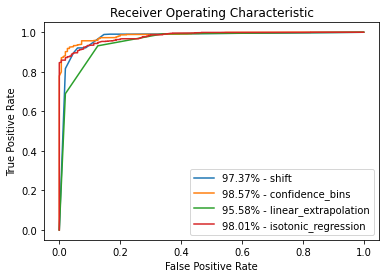

In [10]:
plt.figure()
data = []
for e in experiments:
    y_true = [1 if y==p else 0 for y,p in zip(e['y_test'], e['svc_test_pred'])]
    fpr, tpr, thresholds = roc_curve(y_true, e['pp_test_score'], pos_label=1)
    auc = roc_auc_score(y_true, e['pp_test_score'])
    plt.plot(fpr, tpr, label=f'{auc:.2%} - {e["calibrator"]}')

    acc, th, tl, fh, fl = check_correctness(e['y_test'],  e['svc_test_pred'],  e['pp_test_score'])
    data.append({'calibrator': e['calibrator'],
                 'pp fit size': len(e['y_test']),
                 'svc accuracy': acc,
                 'pp accuracy': e['pp_test_accuracy'],
                 'TH': th,
                 'TL': tl,
                 'FH': fh,
                 'FL': fl,
                 'AUC': auc,
    })
    
pct_fmt = '{:,.2%}'.format
fmt = {col: pct_fmt for col in ['svc accuracy', 'pp accuracy', 'TH', 'TL', 'FH', 'FL', 'AUC']}
display(HTML(pd.DataFrame(data).to_html(formatters=fmt)))

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()